# Data Preparation

In [2]:
from comet_ml import Experiment
import sys
sys.path.append('../ift6758/data/')
from question_2_m2 import *
from question_4_m2 import get_new_features, get_angle_change
import sys
sys.path.append('../ift6758/visualizations/')
from question_6_neural_net_plots import *

import numpy as np
import json
import time
import json
import pandas as pd
import torch
import math
import os
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

In [3]:
my_key = os.environ.get("COMET_API_KEY")

In [4]:
df = pd.read_csv('final_df.csv')
df_train = df[df['season'] != 20192020]
df_test = df[df['season'] == 20192020]

manual feature selection

In [5]:
old_feat = ['game_id', 'Unnamed: 0', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'previous_attacking_team',
       'attacking_team_side']

df_feat = df.iloc[:,:60].columns.tolist()
print(len(df_feat))

#features extracted in question 4
new_feat = [feat for feat in df_feat if feat not in old_feat]

df_train = df_train[new_feat]

60


## Min Max Normalisation

In [8]:
cols_to_normalize = list(df_train.columns)
cols_to_normalize.remove('season')
cols_to_normalize.remove('goal_ind')

for col in cols_to_normalize:
    df_train[col] = (df_train[col] - min(df_train[col]))/(max(df_train[col])-min(df_train[col]))

## Create Train and Validation Sets Two Different Ways

First, we go with a random split

In [9]:
X = df_train.drop(columns = ['season', 'goal_ind'])
Y = df_train['goal_ind']

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.25, random_state=1)

In [10]:
X_train = torch.tensor(X_train.to_numpy()).float()
X_valid = torch.tensor(X_valid.to_numpy()).float()

y_train = torch.tensor(y_train.to_numpy())
y_valid = torch.tensor(y_valid.to_numpy())

Next, we use the 20182019 season as our validation set

In [11]:
df_train2 = df_train[df_train['season'] != 20182019]
df_valid2 = df_train[df_train['season'] == 20182019]

X_train2 = df_train2.drop(columns = ['season', 'goal_ind'])
y_train2 = df_train2['goal_ind']

X_valid2 = df_valid2.drop(columns = ['season', 'goal_ind'])
y_valid2 = df_valid2['goal_ind']

In [12]:
X_train2 = torch.tensor(X_train2.to_numpy()).float()
X_valid2 = torch.tensor(X_valid2.to_numpy()).float()

y_train2 = torch.tensor(y_train2.to_numpy())
y_valid2 = torch.tensor(y_valid2.to_numpy())

## 2 layer Neural Net Softmax Classifier

In [13]:
experiment = Experiment(
    api_key=my_key,
    project_name="neural_net",
    workspace="kleitoun",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/neural-net/53b11ebc6a624822b5f4126253312851



1
2
3
4
5
6
7
8
9


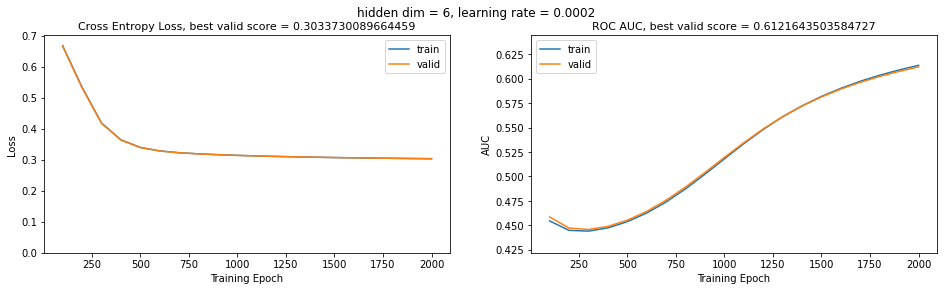

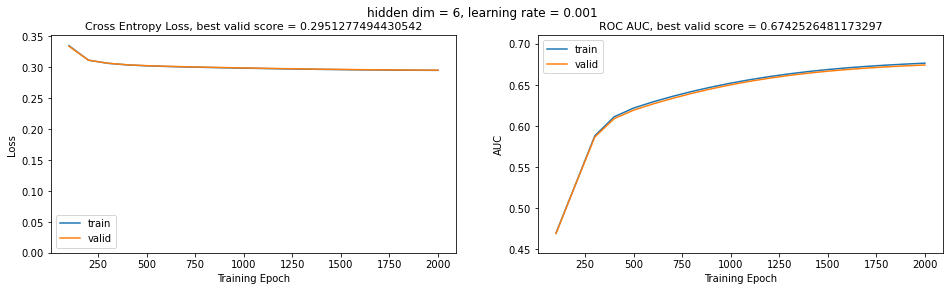

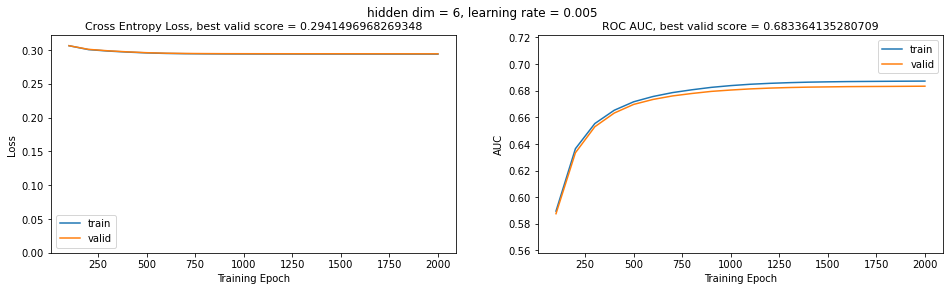

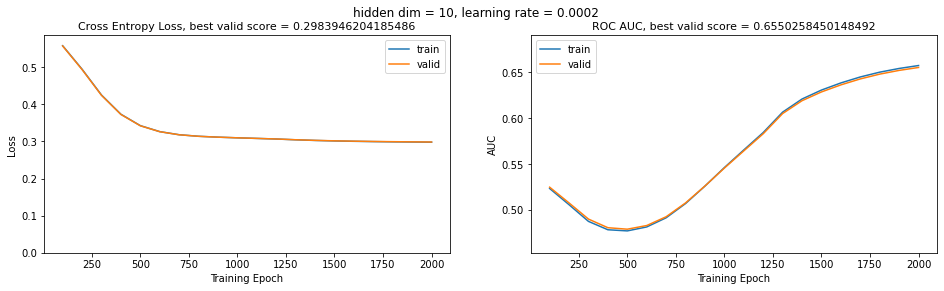

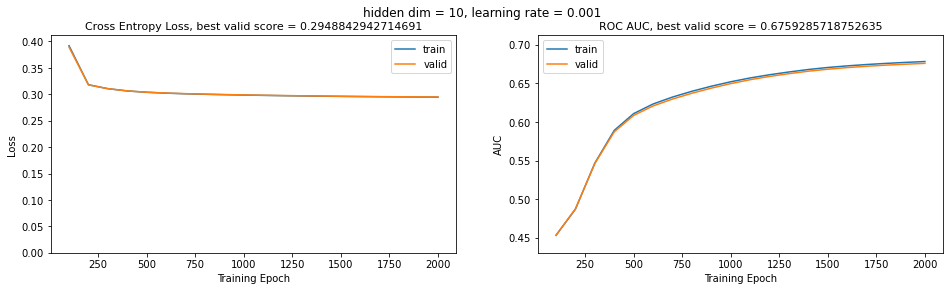

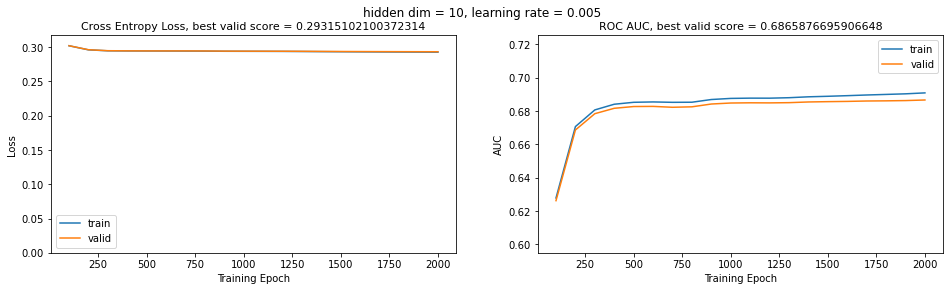

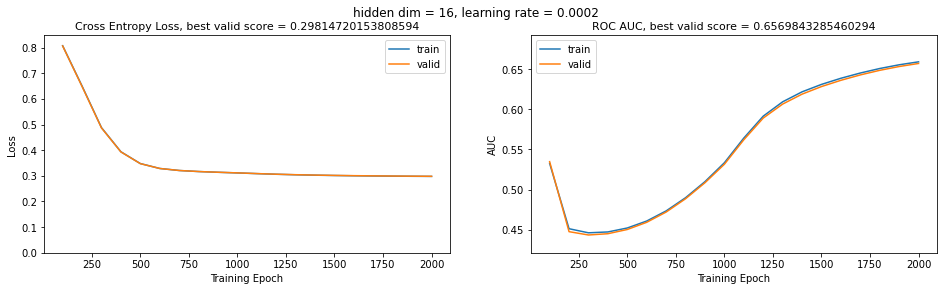

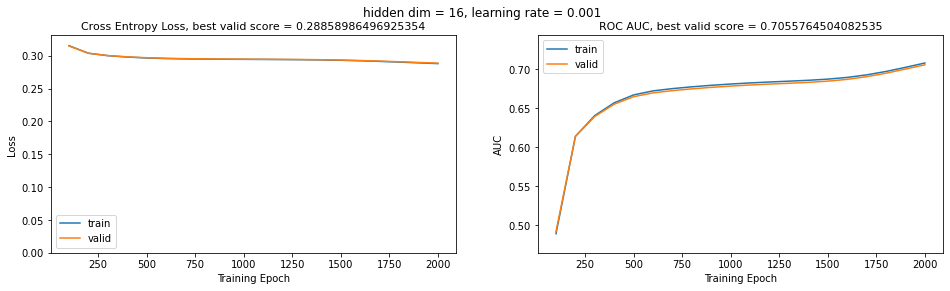

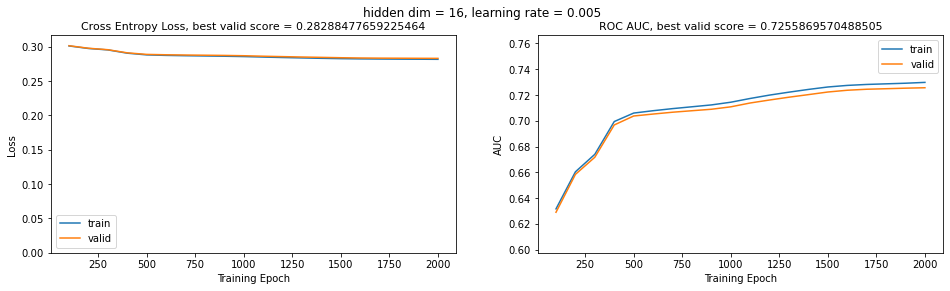

In [14]:
jj=1
for hidden_dim in [6, 10, 16]:
    for lr in [0.0002, 0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dim)
                self.layer2 = nn.Linear(hidden_dim, 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = self.layer2(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dim = {hidden_dim}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        
        experiment.log_figure(figure=fig, figure_name=f'training curves for hidden dim = {hidden_dim}, learning rate = {lr}')
        
        print(jj)
        jj += 1

## 3 layer Neural Net softmax classifier

1
2
3
4


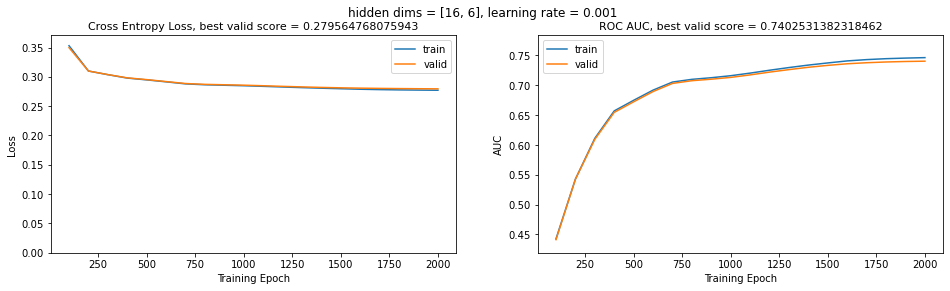

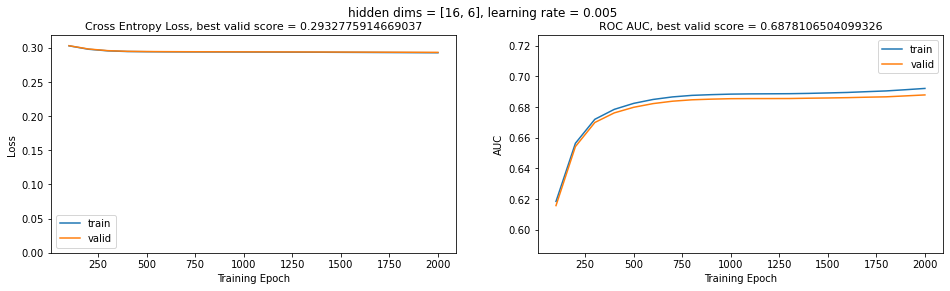

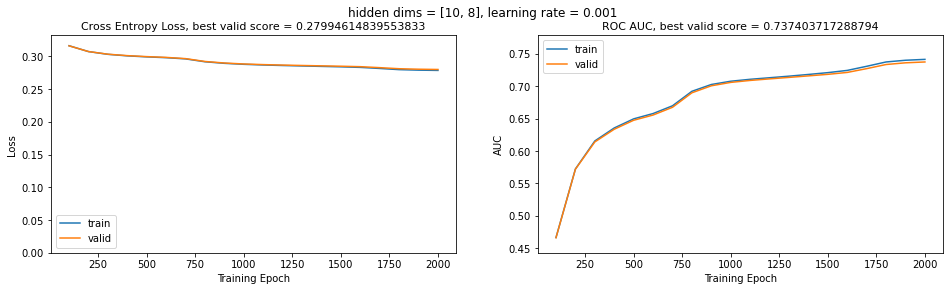

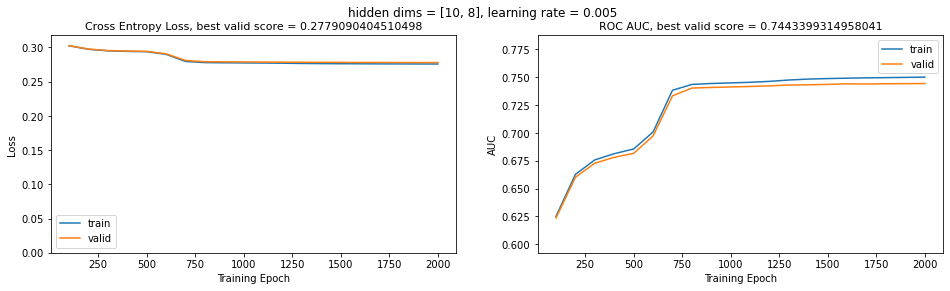

In [15]:
jj=1
for hidden_dims in [[16,6], [10,8]]:
    for lr in [0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
                self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
                self.layer3 = nn.Linear(hidden_dims[1], 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                x = self.layer3(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        
        experiment.log_figure(figure=fig, figure_name=f'training curves for hidden dim = {hidden_dims}, learning rate = {lr}')
        
        print(jj)
        jj += 1

## 4 layer Neural Net softmax classifier

1
2


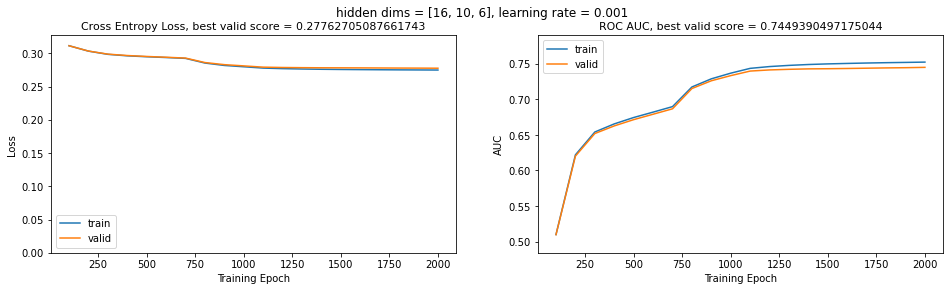

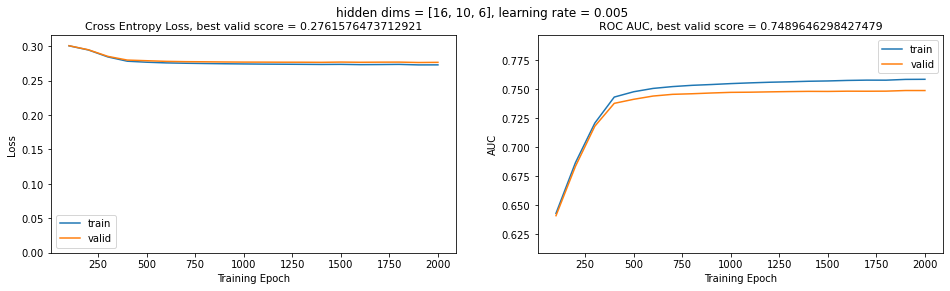

In [16]:
jj=1
for hidden_dims in [[16,10,6]]:
    for lr in [0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
                self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
                self.layer3 = nn.Linear(hidden_dims[1], hidden_dims[2])
                self.layer4 = nn.Linear(hidden_dims[2], 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                x = F.relu(self.layer3(x))
                x = self.layer4(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        
        experiment.log_figure(figure=fig, figure_name=f'training curves for hidden dim = {hidden_dims}, learning rate = {lr}')
        
        print(jj)
        jj += 1

In [17]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kleitoun/neural-net/53b11ebc6a624822b5f4126253312851
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3000] : (0.27263572812080383, 0.9093848466873169)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 15
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (697.87 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several secon

## Retrain final model with best hyperparams for a bit longer

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/neural-net/f6b8ce4a119e4143abbc98bbbc55edd8

COMET WARNING: Cannot safely convert [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000] object to a scalar value, using its string representation for logging.
COMET WARNING: Cannot safely convert [0.31394699215888977, 0.30460286140441895, 0.2986767590045929, 0.2966579496860504, 0.2954939305782318, 0.2946775257587433, 0.2942032217979431, 0.29389315843582153, 0.2936936020851135, 0.29352909326553345, 0.2933766543865204, 0.29320091009140015, 0.2930465042591095, 0.29293063282966614, 0.2927634119987488, 0.2915753722190857, 0.290

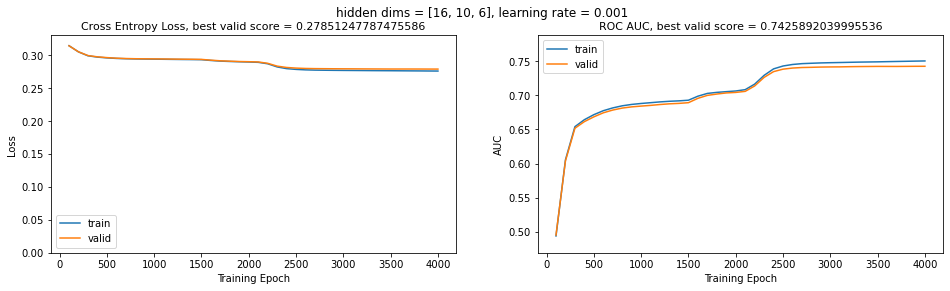

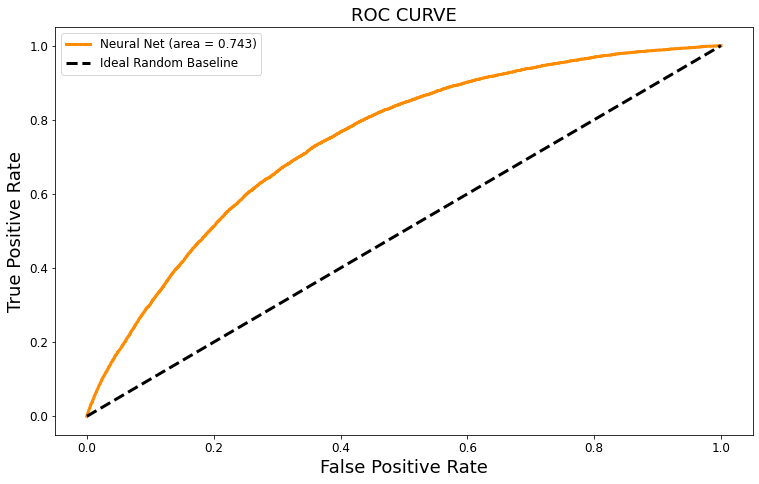

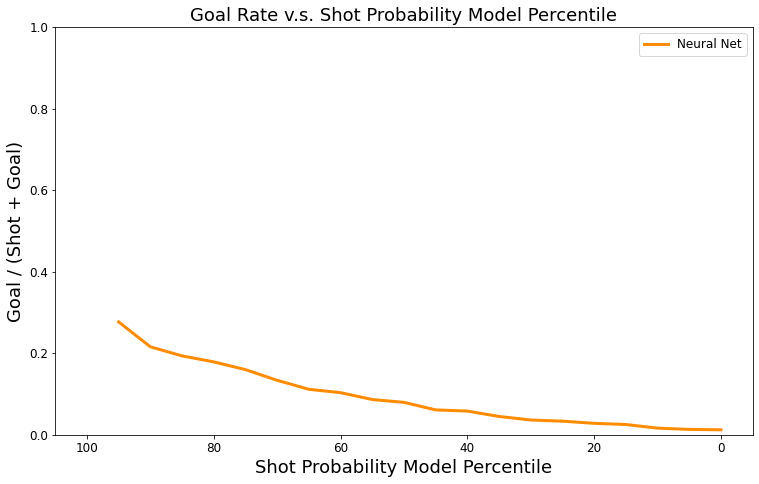

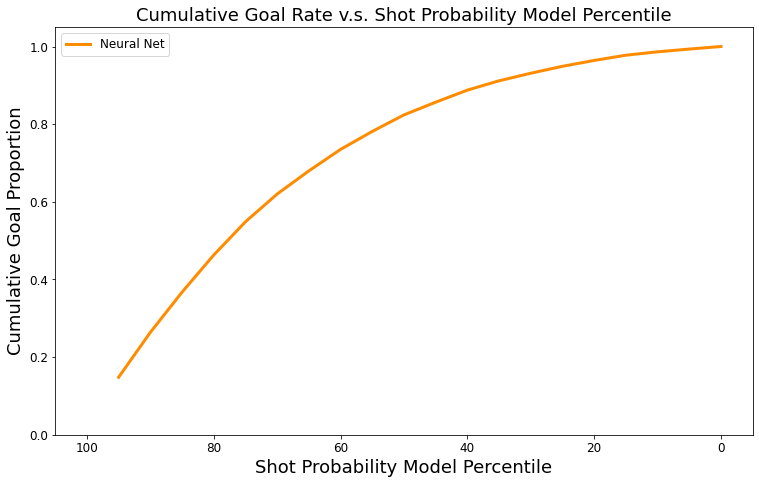

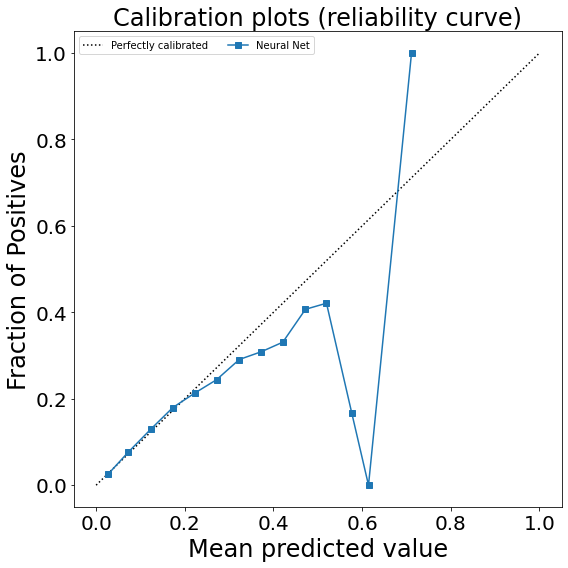

In [41]:
experiment = Experiment(
    api_key=my_key,
    project_name="neural_net",
    workspace="kleitoun",
)

hidden_dims = [16,10,6]
lr = 0.001
epochs = 4000

params = {
  "Layer hidden dimensions": hidden_dims,
  "learning rate":lr,
  "epochs":epochs
}

experiment.log_parameters(params)


# model class
class binary_classifier(nn.Module):

    def __init__(self):
        super(binary_classifier,self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.layer3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.layer4 = nn.Linear(hidden_dims[2], 2)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

    #This function takes an input and predicts the class, (0 or 1)        
    def predict_class(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

    def predict_probs(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        return pred

# initialise model
model = binary_classifier()
loss_computation = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Store metrics
epochs_list = []
losses = []
losses_valid = []
train_rocs = []
valid_rocs = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = loss_computation(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        preds = model.predict_probs(X_train)
        goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
        fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
        roc_auc = auc(fpr, tpr)

        preds_valid = model.predict_probs(X_valid)
        goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
        fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
        roc_auc_valid = auc(fpr_valid, tpr_valid)

        y_pred_valid = model.forward(X_valid)
        loss_valid = loss_computation(y_pred_valid, y_valid)

        epochs_list.append(i+1)
        losses.append(loss.item())
        losses_valid.append(loss_valid.item())
        train_rocs.append(roc_auc)
        valid_rocs.append(roc_auc_valid)

# plot metrics
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
axs[0].plot(epochs_list, losses)
axs[0].plot(epochs_list, losses_valid)
axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
axs[0].legend(labels = ['train', 'valid'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training Epoch')
axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])

axs[1].plot(epochs_list, train_rocs)
axs[1].plot(epochs_list, valid_rocs)
axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
axs[1].legend(labels = ['train', 'valid'])
axs[1].set_ylabel('AUC')
axs[1].set_xlabel('Training Epoch')
axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
experiment.log_figure(figure=fig, figure_name='Training Loss and ROC AUC')

metrics = {
    "trainig epoch": epochs_list,
    "trainig loss": losses,
    "validation loss": losses_valid,
    "trainig roc": train_rocs,
    "validation roc": valid_rocs,
}
experiment.log_metrics(metrics)

fig = plot_roc(
    preds_valid[:,goal_index_valid].detach().numpy(),
    y_valid.detach().numpy(),
    save_path = '../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_ROC_Curve.png'
)
experiment.log_figure(figure=fig, figure_name='ROC')

percentile_df = prep_percentile_df(
    y_valid.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy()
)

fig = plot_goal_rate(percentile_df, save_path='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Goal_Rate.png')
experiment.log_figure(figure=fig, figure_name='Goal Rate')

fig = plot_cum_goal_rate(percentile_df, save_path='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Cum_Goal.png')
experiment.log_figure(figure=fig, figure_name='Cumulative Goal Rate')


fig = plot_calibration_curve(
    y_valid.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy(),
    save_path ='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Calibration_Curve.png'
)
experiment.log_figure(figure=fig, figure_name='Calibration Curve')

torch.save(model.state_dict(), 'q6_neural_net_final')
experiment.log_model('nn_final', 'q6_neural_net_final')

experiment.end()

## Retrain same model with second train/valid split

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/neural-net/d193966f5e7d4a439c0f7153120a84cd

COMET WARNING: Cannot safely convert [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000] object to a scalar value, using its string representation for logging.
COMET WARNING: Cannot safely convert [0.5253771543502808, 0.30408981442451477, 0.29517751932144165, 0.2927015423774719, 0.2903963327407837, 0.2872371971607208, 0.2846542000770569, 0.2819161117076874, 0.27908286452293396, 0.277240127325058, 0.27598118782043457, 0.27537521719932556, 0.27505406737327576, 0.2747545838356018, 0.2744988799095154, 0.27428266406059265, 0.274

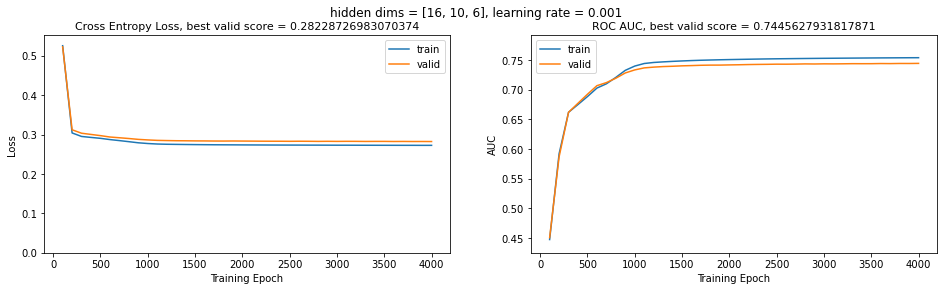

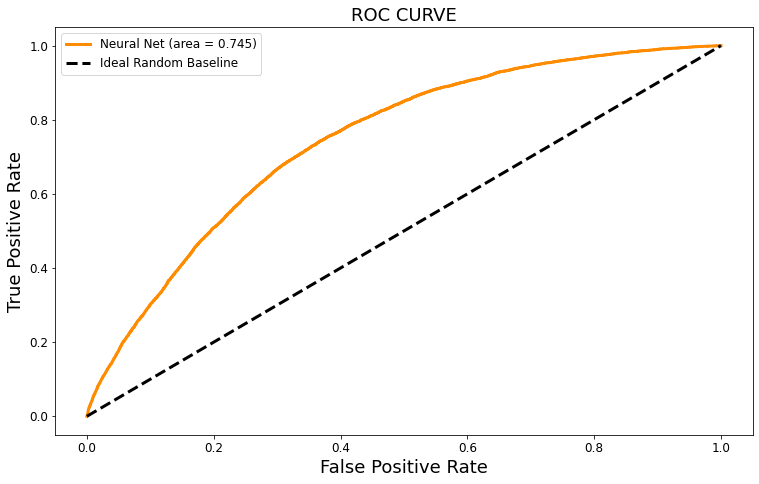

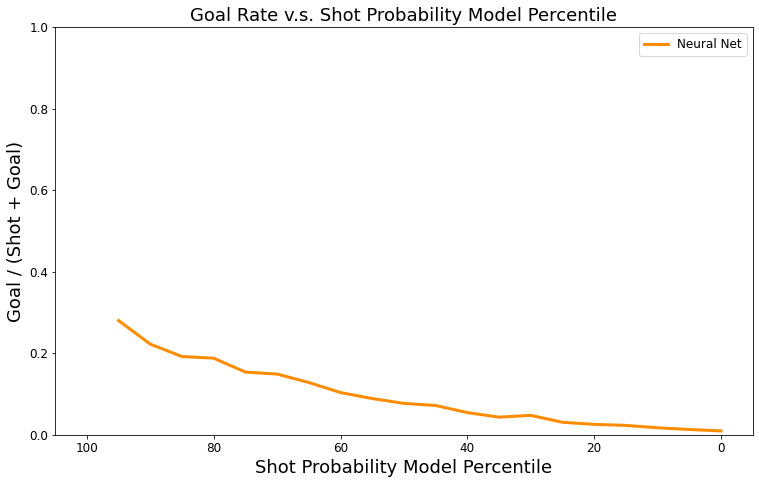

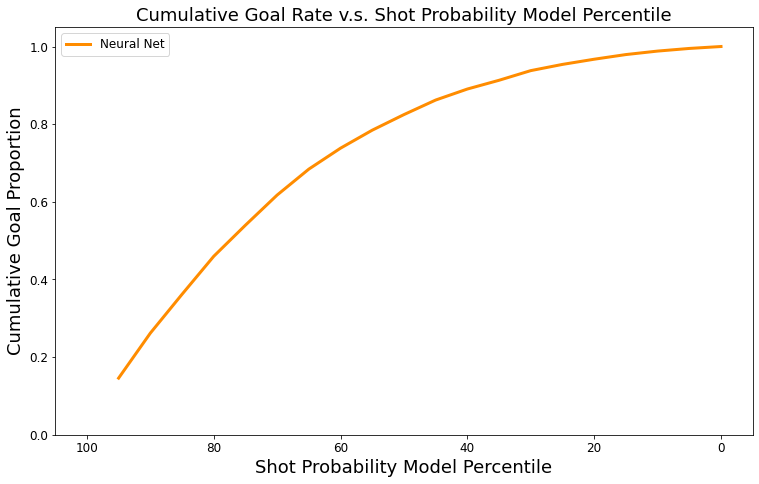

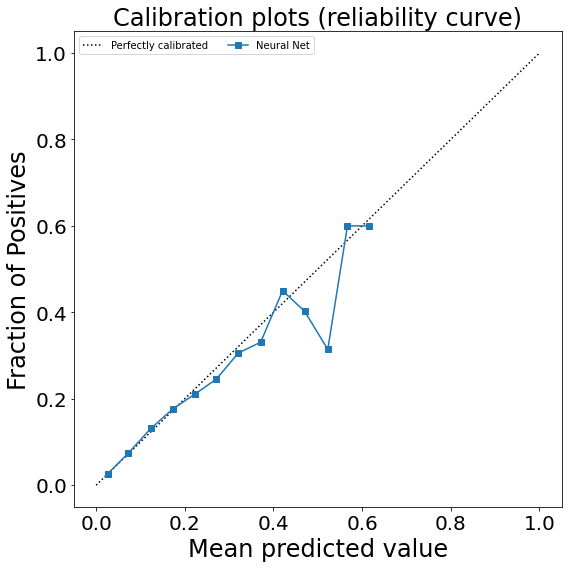

In [42]:
experiment = Experiment(
    api_key= my_key,
    project_name="neural_net",
    workspace="kleitoun",
)

hidden_dims = [16,10,6]
lr = 0.001
epochs = 4000

params = {
  "Layer hidden dimensions": hidden_dims,
  "learning rate":lr,
  "epochs":epochs
}

experiment.log_parameters(params)


# model class
class binary_classifier(nn.Module):

    def __init__(self):
        super(binary_classifier,self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.layer3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.layer4 = nn.Linear(hidden_dims[2], 2)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

    #This function takes an input and predicts the class, (0 or 1)        
    def predict_class(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

    def predict_probs(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        return pred

# initialise model
model = binary_classifier()
loss_computation = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Store metrics
epochs_list = []
losses = []
losses_valid = []
train_rocs = []
valid_rocs = []

for i in range(epochs):
    y_pred = model.forward(X_train2)
    loss = loss_computation(y_pred,y_train2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        preds = model.predict_probs(X_train2)
        goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
        fpr, tpr, _ = roc_curve(np.array(y_train2), preds[:,goal_index].detach().numpy())
        roc_auc = auc(fpr, tpr)

        preds_valid = model.predict_probs(X_valid2)
        goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
        fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid2), preds_valid[:,goal_index_valid].detach().numpy())
        roc_auc_valid = auc(fpr_valid, tpr_valid)

        y_pred_valid = model.forward(X_valid2)
        loss_valid = loss_computation(y_pred_valid, y_valid2)

        epochs_list.append(i+1)
        losses.append(loss.item())
        losses_valid.append(loss_valid.item())
        train_rocs.append(roc_auc)
        valid_rocs.append(roc_auc_valid)

# plot metrics
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
axs[0].plot(epochs_list, losses)
axs[0].plot(epochs_list, losses_valid)
axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
axs[0].legend(labels = ['train', 'valid'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training Epoch')
axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])

axs[1].plot(epochs_list, train_rocs)
axs[1].plot(epochs_list, valid_rocs)
axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
axs[1].legend(labels = ['train', 'valid'])
axs[1].set_ylabel('AUC')
axs[1].set_xlabel('Training Epoch')
axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
experiment.log_figure(figure=fig, figure_name='Training Loss and ROC AUC')

metrics = {
    "trainig epoch": epochs_list,
    "trainig loss": losses,
    "validation loss": losses_valid,
    "trainig roc": train_rocs,
    "validation roc": valid_rocs,
}
experiment.log_metrics(metrics) 

fig = plot_roc(
    preds_valid[:,goal_index_valid].detach().numpy(),
    y_valid2.detach().numpy(),
    save_path = '../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_ROC_Curve_season_split.png'
)
experiment.log_figure(figure=fig, figure_name='ROC')

percentile_df = prep_percentile_df(
    y_valid2.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy()
)

fig = plot_goal_rate(percentile_df, save_path='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Goal_Rate_season_split.png')
experiment.log_figure(figure=fig, figure_name='Goal Rate')

fig = plot_cum_goal_rate(percentile_df, save_path='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Cum_Goal_season_split.png')
experiment.log_figure(figure=fig, figure_name='Cumulative Goal Rate')


fig = plot_calibration_curve(
    y_valid2.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy(),
    save_path ='../../ift6758-blog-template-main/figures/milestone2/Q6_neural_net_Calibration_Curve_season_split.png'
)
experiment.log_figure(figure=fig, figure_name='Calibration Curve')

torch.save(model.state_dict(), 'q6_neural_net_final_season_split')
experiment.log_model('nn_final_season_split', 'q6_neural_net_final_season_split')

experiment.end()